In [39]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
from torch import nn
import numpy as np

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_transform = transforms.Compose([ # cria uma pipeline de transformações de imagens
    transforms.ToTensor(), # transforma as imagens em tensores
    transforms.Normalize([0.5], [0.5]), # normaliza os dados com x_{i+1} = (x_i - 0.5)/0.5
    transforms.Lambda(lambda x: x.to(device)) # armazena todas as imagens em device
])
data_folder = '/kaggle/working/'
trn_ds = MNIST(data_folder, transform=img_transform, download=True, train = True)
val_ds = MNIST(data_folder, transform=img_transform, download=True, train = False)

In [41]:
batch_size = 128
trn_dl = DataLoader(trn_ds, batch_size = batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = batch_size, shuffle=False)

In [42]:
# criação da classe construtora do autoencoder
class ConvAutoEncoder(nn.Module): # herda da classe nn.Module
    def __init__(self):
        super().__init__() # inicializa os métodos e atributos da classe herdada
        self.encoder = nn.Sequential( # encoder é uma rede sequencial
            nn.Conv2d(1, 32, 3, stride = 3, padding = 1), # in: 1 canal; process: stride de 3 pixels e padding de 1 pixel; out 32 feature maps
            nn.ReLU(True), # aplica a ReLU inplace
            nn.MaxPool2d(2, stride = 2), # pool size de 2x2 e stride de 2
            nn.Conv2d(32, 64, 3, stride = 2, padding = 1), #in: 32 feature maps; out: 64 feature maps
            nn.ReLU(True),
            nn.MaxPool2d(2, stride = 1)
        )
        self.decoder = nn.Sequential( # decoder também é uma rede sequencial
            nn.ConvTranspose2d(64, 32, 3, stride=2), # faz convolução transposta, diminuindo a quantidade de feature maps e aumentando as dimensões espaciais
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride = 2, padding = 1), # retorna um output com o tamanho da imagem original
            nn.Tanh()
        )
    def forward(self, x): # passa a imagem pelo encoder e decoder
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [43]:
model = ConvAutoEncoder().to(device) # cria uma instância do aec com CNN e o armazena em device
!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros(2, 1, 28, 28)) # cria um resumo de model, tomando como input de referência um tensor zerado de 2x1x28x28, 2 batches de imagens 28x28 com 1 canal de cor

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [44]:
# função de treina com batch
def train_batch(model, input_, loss_fn, opt):
    model.train() # coloca o modelo em modo treino
    predictions = model(input_) # codifica e decodifica as imagens em input_
    loss = loss_fn(predictions, input_) # calcula o erro entre o output e o input
    loss.backward() # calcula os gradientes por backpropagation
    opt.step() # atualiza os pesos
    opt.zero_grad() # zera o tensor de gradientes do otimizador
    return loss.item()

In [45]:
# função de validação por batch
@torch.no_grad() # desativa o cálculo dos gradientes para modelos pytorch dentro da função seguinte
def validate_batch(model, input_, loss_fn):
    model.eval() # coloca o modelo em modo treino
    predictions = model(input_)
    loss = loss_fn(predictions, input_)
    return loss.item()

In [46]:
from torch.optim import AdamW
loss_fn = nn.MSELoss() # define a função de erro como a Mean Squared Error
opt = AdamW(model.parameters(), lr = 1e-3, weight_decay = 1e-5) # define o otimizador como sendo o Adam com weight decay

In [47]:
# loop de treino e validação

num_epochs = 5 # 5 epochs pelo grande tamanho dos datasets
train_epoch_losses, val_epoch_losses = [], []

for epoch in range(num_epochs):
    print(epoch)
    train_batch_losses, val_batch_losses = [], []
    
    #loop de treino
    for data, _ in iter(trn_dl): # data: imagens; _: classes das imagens, que não interesse nessa aplicação
        batch_loss = train_batch(model, data, loss_fn, opt) # treina o modelo com o batch e captura o erro
        train_batch_losses.append(batch_loss)
    train_epoch_losses.append(np.array(train_batch_losses).mean())
    
    #loop de validação
    for data, _ in iter(val_dl):
        batch_loss = validate_batch(model, data, loss_fn)
        val_batch_losses.append(batch_loss)
    val_epoch_losses.append(np.array(val_batch_losses).mean())

0
1
2
3
4


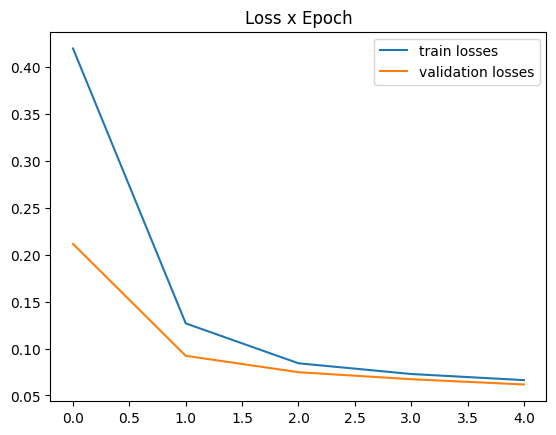

In [48]:
# plotando os erros por epoch
import matplotlib.pyplot as plt
plt.plot(train_epoch_losses, label = 'train losses')
plt.plot(val_epoch_losses, label = 'validation losses')
plt.title('Loss x Epoch')
plt.legend()

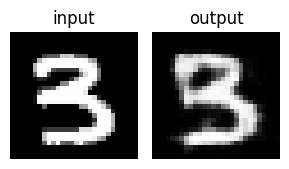

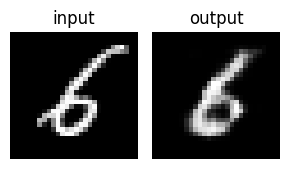

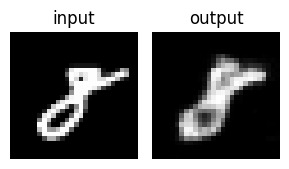

In [51]:
# visualizando alguns exemplos 
for _ in range(3):
    ix = np.random.randint(len(val_ds)) # pega um índice aleatório do dataset de validação
    im, _ = val_ds[ix] # pega uma imagem com o índice
    _im = model(im[None])[0] # pega o output do modelo para a imagem im
    fig, ax = plt.subplots(1, 2, figsize=(3,3)) # cria uma figura com 2 subplots de 3x3 polegadas
    ax[0].imshow(im[0].cpu().detach().numpy(), cmap='gray') # plota o input no primeiro subplot
    ax[1].imshow(_im[0].cpu().detach().numpy(), cmap='gray') # plota o output no segundo subplot
    ax[0].set_title('input')
    ax[1].set_title('output')
    ax[0].axis('off') # tira os eixos do subplot
    ax[1].axis('off')
    plt.tight_layout() # ajustao espaçamento entre os subplots
    plt.show()